# Build a Baseline Model

Here I build a baseline model for comparison with model building in the future.

### Load Modules

In [248]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima import auto_arima
import datetime
%matplotlib inline

In [249]:
!ls 1.collect_data/

1.1_Get_All_Parking_Zones.ipynb       README.md
1.2_Get_Detailed_Blockface_Info.ipynb Test_Collecting_Data.ipynb
1.3_Get_Parking_Data.ipynb            block_locations.csv
1.4_Format_archived_data.ipynb        blockface_detail.csv
1.5_Process_Weather_Data.ipynb        data_by_day.pkl
2019.1001.pkl                         data_files
2019.1002.pkl                         failed
2019.1006.pkl                         seattle_map.png
GetParkingData.py


In [250]:
blockface_detail = pd.read_csv('1.collect_data/blockface_detail.csv')

In [251]:
blockface_detail_locs = blockface_detail[['latitude', 'longitude', 'sourceelementkey']]
blockface_detail_locs.head()

,latitude,longitude,sourceelementkey
0,47.602873,-122.334694,1001
1,47.602949,-122.334513,1002
2,47.603674,-122.335143,1006
3,47.605018,-122.336658,1009
4,47.605101,-122.336447,1010


Load in dataframe 

In [252]:
df = pd.read_pickle('1.collect_data/data_files/1hr.pkl').replace([np.inf, -np.inf], np.nan).dropna()

In [253]:
df.head()

PaidOccupancy  ParkingSpaceCount  \
SourceElementKey OccupancyDateTime                                       
1001             2012-01-03 09:00:00       0.983333                7.0   
                 2012-01-03 10:00:00       2.016667                7.0   
                 2012-01-03 11:00:00       4.633333                7.0   
                 2012-01-03 12:00:00       3.283333                7.0   
                 2012-01-03 13:00:00       1.116667                7.0   

                                      PercentOccupied  
SourceElementKey OccupancyDateTime                     
1001             2012-01-03 09:00:00         0.140476  
                 2012-01-03 10:00:00         0.288095  
                 2012-01-03 11:00:00         0.661905  
                 2012-01-03 12:00:00         0.469048  
                 2012-01-03 13:00:00         0.159524

Reset index required to use the blockID and datetime as parameters for the model

In [254]:
df.reset_index(inplace=True)

In [255]:
last_two_years = df[df['OccupancyDateTime'] > '2018-01-01 00:00:00']

In [256]:
last_two_years.head()

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied
18164,1001,2018-01-02 09:00:00,0.000000,5.0,0.000000
18165,1001,2018-01-02 10:00:00,0.000000,5.0,0.000000
18166,1001,2018-01-02 11:00:00,0.000000,5.0,0.000000
18167,1001,2018-01-02 12:00:00,0.116667,5.0,0.023333
18168,1001,2018-01-02 13:00:00,0.000000,5.0,0.000000


In [257]:
last_two_years.tail().OccupancyDateTime.dt.dayofweek

38586661    4
38586662    4
38586663    4
38586664    4
38586665    4
Name: OccupancyDateTime, dtype: int64

In [258]:
merged = pd.merge(last_two_years, 
                  blockface_detail_locs, 
                  how='left', 
                  left_on='SourceElementKey', 
                  right_on='sourceelementkey').drop('sourceelementkey', axis=1)

In [259]:
merged.tail()

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied,latitude,longitude
8646182,121340,2019-08-30 13:00:00,1.100000,2.0,0.550000,47.624221,-122.333423
8646183,121340,2019-08-30 14:00:00,0.916667,2.0,0.458333,47.624221,-122.333423
8646184,121340,2019-08-30 15:00:00,0.633333,2.0,0.316667,47.624221,-122.333423
8646185,121340,2019-08-30 16:00:00,0.000000,2.0,0.000000,47.624221,-122.333423
8646186,121340,2019-08-30 17:00:00,0.000000,2.0,0.000000,47.624221,-122.333423


Here I add month,day, year etc. so that the ML model can be trained on them.

In [260]:
merged['Month'] = merged.OccupancyDateTime.dt.month
merged['Year'] = merged.OccupancyDateTime.dt.year
merged['Hour'] = merged.OccupancyDateTime.dt.hour
merged['DayOfWeek'] = merged.OccupancyDateTime.dt.dayofweek
merged['Day'] = merged.OccupancyDateTime.dt.day

In [261]:
merged['Dummy'] = 0

In [262]:
merged.head()

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied,latitude,longitude,Month,Year,Hour,DayOfWeek,Day,Dummy
0,1001,2018-01-02 09:00:00,0.000000,5.0,0.000000,47.602873,-122.334694,1,2018,9,1,2,0
1,1001,2018-01-02 10:00:00,0.000000,5.0,0.000000,47.602873,-122.334694,1,2018,10,1,2,0
2,1001,2018-01-02 11:00:00,0.000000,5.0,0.000000,47.602873,-122.334694,1,2018,11,1,2,0
3,1001,2018-01-02 12:00:00,0.116667,5.0,0.023333,47.602873,-122.334694,1,2018,12,1,2,0
4,1001,2018-01-02 13:00:00,0.000000,5.0,0.000000,47.602873,-122.334694,1,2018,13,1,2,0


In [263]:
merged.isna().sum()

SourceElementKey         0
OccupancyDateTime        0
PaidOccupancy            0
ParkingSpaceCount        0
PercentOccupied          0
latitude             78541
longitude            78541
Month                    0
Year                     0
Hour                     0
DayOfWeek                0
Day                      0
Dummy                    0
dtype: int64

In [268]:
# y = df['PercentOccupied'].values
# X = df[['Dummy', 'SourceElementKey']]

Split the data into train and test sets

In [269]:
df_train, df_test = train_test_split(
    merged, test_size=0.3, random_state=42)

In [270]:
baseline_columns = ['Dummy', 'SourceElementKey']

In [271]:
df_train.head()

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied,latitude,longitude,Month,Year,Hour,DayOfWeek,Day,Dummy
7651485,88774,2018-02-23 17:00:00,4.283333,8.0,0.535417,47.599962,-122.325679,2,2018,17,4,23,0
7468644,82654,2019-07-20 20:00:00,2.016667,3.0,0.672222,47.625181,-122.320511,7,2019,20,5,20,0
2972822,34837,2019-03-23 09:00:00,3.400000,4.0,0.850000,47.610500,-122.336214,3,2019,9,5,23,0
249555,2786,2018-11-29 09:00:00,4.783333,6.0,0.797222,47.616794,-122.350138,11,2018,9,3,29,0
7052602,80598,2019-07-05 10:00:00,4.066667,8.0,0.508333,47.676221,-122.317275,7,2019,10,4,5,0


Build the actual dataset objects for LightGBM

In [275]:
lgb_train = lgb.Dataset(data=df_train[baseline_columns], 
                        label=df_train['PercentOccupied'], 
                        feature_name=baseline_columns, 
                        categorical_feature=['SourceElementKey'])
lgb_test = lgb.Dataset(data=df_test[baseline_columns], 
                       label=df_test['PercentOccupied'], 
                       feature_name=baseline_columns, 
                       categorical_feature=['SourceElementKey'],
                       reference=lgb_train)

Set the parameters for the ML model

In [276]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}

Train model only on dummy variable and blockID

In [277]:
#gbm = lgb.Booster(model_file='baseline_model.txt')

In [278]:
print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
               valid_sets=lgb_test)

print('Saving model...')
# save model to file
gbm.save_model('baseline_model.txt')

Starting training...


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's l2: 0.139154	valid_0's l1: 0.284705
[2]	valid_0's l2: 0.134714	valid_0's l1: 0.279733
[3]	valid_0's l2: 0.130703	valid_0's l1: 0.275131
[4]	valid_0's l2: 0.127081	valid_0's l1: 0.270888
[5]	valid_0's l2: 0.123803	valid_0's l1: 0.266918
[6]	valid_0's l2: 0.120847	valid_0's l1: 0.263266
[7]	valid_0's l2: 0.118163	valid_0's l1: 0.259878
[8]	valid_0's l2: 0.115739	valid_0's l1: 0.256695
[9]	valid_0's l2: 0.113538	valid_0's l1: 0.253775
[10]	valid_0's l2: 0.111552	valid_0's l1: 0.251031
[11]	valid_0's l2: 0.109746	valid_0's l1: 0.248515
[12]	valid_0's l2: 0.108113	valid_0's l1: 0.246139
[13]	valid_0's l2: 0.106634	valid_0's l1: 0.243962
[14]	valid_0's l2: 0.105301	valid_0's l1: 0.241922
[15]	valid_0's l2: 0.104082	valid_0's l1: 0.240053
[16]	valid_0's l2: 0.102984	valid_0's l1: 0.238289
[17]	valid_0's l2: 0.101991	valid_0's l1: 0.23668
[18]	valid_0's l2: 0.101087	valid_0's l1: 0.235161
[19]	valid_0's l2: 0.10026	valid_0's l1: 0.233777
[20]	valid_0's l2: 0.0995164	valid_0's l1:

In [279]:
y_pred = gbm.predict(df_test[baseline_columns], num_iteration=gbm.best_iteration)

In [280]:
def smape_error(forecast, actual):
    numerator = np.absolute(forecast-actual)
    denominator = np.absolute(forecast) + np.absolute(actual)

    num_samples = len(numerator)

    return 100/num_samples * np.sum(numerator/denominator)

In [281]:
baseline_smape = smape_error(y_pred, df_test['PercentOccupied'])
print('smape: %f' % baseline_smape)

smape: 32.299322


# Simple Model

Build a simple model only on datetime info and blockID

In [282]:
df.tail().OccupancyDateTime.dt.day

38586661    30
38586662    30
38586663    30
38586664    30
38586665    30
Name: OccupancyDateTime, dtype: int64

In [283]:
simple_columns = ['SourceElementKey', 'Year', 'Hour', 'DayOfWeek']

In [284]:
simple_train = lgb.Dataset(data=df_train[simple_columns], 
                           label=df_train['PercentOccupied'],
                            feature_name=simple_columns, 
                       categorical_feature=['SourceElementKey', 'DayOfWeek'])
simple_test = lgb.Dataset(data=df_test[simple_columns], 
                          label=df_test['PercentOccupied'], 
                          feature_name=simple_columns, 
                          categorical_feature=['SourceElementKey', 'DayOfWeek'],
                          reference=simple_train)

In [285]:
gbm_simple = lgb.Booster(model_file='simple_ml_model.txt')

print('Starting training...')
# train
gbm_simple = lgb.train(params,
                simple_train,
                valid_sets=simple_test)

print('Saving model...')
# save model to file
gbm_simple.save_model('simple_ml_model.txt')

Starting training...
[1]	valid_0's l2: 0.138671	valid_0's l1: 0.284235
[2]	valid_0's l2: 0.137773	valid_0's l1: 0.283127
[3]	valid_0's l2: 0.132943	valid_0's l1: 0.277751
[4]	valid_0's l2: 0.128854	valid_0's l1: 0.273025
[5]	valid_0's l2: 0.128094	valid_0's l1: 0.272044
[6]	valid_0's l2: 0.124133	valid_0's l1: 0.267398
[7]	valid_0's l2: 0.120537	valid_0's l1: 0.263087
[8]	valid_0's l2: 0.119926	valid_0's l1: 0.262266
[9]	valid_0's l2: 0.119376	valid_0's l1: 0.261513
[10]	valid_0's l2: 0.118877	valid_0's l1: 0.260819
[11]	valid_0's l2: 0.118426	valid_0's l1: 0.260181
[12]	valid_0's l2: 0.115355	valid_0's l1: 0.256285
[13]	valid_0's l2: 0.112422	valid_0's l1: 0.252529
[14]	valid_0's l2: 0.109773	valid_0's l1: 0.24903
[15]	valid_0's l2: 0.107463	valid_0's l1: 0.245917
[16]	valid_0's l2: 0.105271	valid_0's l1: 0.242885
[17]	valid_0's l2: 0.103366	valid_0's l1: 0.240159
[18]	valid_0's l2: 0.101539	valid_0's l1: 0.237548
[19]	valid_0's l2: 0.101206	valid_0's l1: 0.237036
[20]	valid_0's l2: 0

In [286]:
y_pred = gbm_simple.predict(df_test[simple_columns], num_iteration=gbm_simple.best_iteration)

In [287]:
simple_smape = smape_error(y_pred, df_test['PercentOccupied'])
print('smape: %f' % simple_smape)

smape: 30.724769


This only slightly improves the model compared to the baseline

# Random Forest

In [288]:
rf_columns = ['SourceElementKey', 'Year', 'Hour', 'DayOfWeek', 'latitude', 'longitude']

In [289]:
rf_train = lgb.Dataset(data=df_train[rf_columns], 
                           label=df_train['PercentOccupied'],
                            feature_name=rf_columns, 
                       categorical_feature=['SourceElementKey', 'DayOfWeek', 'Hour'])
rf_test = lgb.Dataset(data=df_test[rf_columns], 
                          label=df_test['PercentOccupied'], 
                          feature_name=rf_columns, 
                          categorical_feature=['SourceElementKey', 'DayOfWeek', 'Hour'],
                          reference=simple_train)

In [290]:
params = {
    'boosting_type': 'rf',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'num_threads':6
    
}

In [291]:
#rf = lgb.Booster(model_file='simple_rf_model.txt')

print('Starting training...')
# train
gbm_rf = lgb.train(params,
                rf_train,
                valid_sets=rf_test)

print('Saving model...')
# save model to file
gbm_rf.save_model('simple_rf_model.txt')

Starting training...
[1]	valid_0's l2: 0.0896648	valid_0's l1: 0.215333
[2]	valid_0's l2: 0.0896648	valid_0's l1: 0.215333
[3]	valid_0's l2: 0.0869283	valid_0's l1: 0.211362
[4]	valid_0's l2: 0.0872189	valid_0's l1: 0.211852
[5]	valid_0's l2: 0.0875192	valid_0's l1: 0.212302
[6]	valid_0's l2: 0.0869554	valid_0's l1: 0.211423
[7]	valid_0's l2: 0.0867471	valid_0's l1: 0.211761
[8]	valid_0's l2: 0.0868148	valid_0's l1: 0.211819
[9]	valid_0's l2: 0.0869262	valid_0's l1: 0.211938
[10]	valid_0's l2: 0.0870522	valid_0's l1: 0.212081
[11]	valid_0's l2: 0.0867043	valid_0's l1: 0.211501
[12]	valid_0's l2: 0.0865079	valid_0's l1: 0.211148
[13]	valid_0's l2: 0.0866394	valid_0's l1: 0.211319
[14]	valid_0's l2: 0.086767	valid_0's l1: 0.211486
[15]	valid_0's l2: 0.0868887	valid_0's l1: 0.211646
[16]	valid_0's l2: 0.086997	valid_0's l1: 0.211788
[17]	valid_0's l2: 0.0869856	valid_0's l1: 0.212022
[18]	valid_0's l2: 0.0866796	valid_0's l1: 0.211551
[19]	valid_0's l2: 0.0867585	valid_0's l1: 0.211645
[2

In [292]:
y_pred = gbm_rf.predict(df_test[rf_columns], num_iteration=gbm_rf.best_iteration)

In [293]:
rf_smape = smape_error(y_pred, df_test['PercentOccupied'])
print('smape: %f' % simple_smape)

smape: 30.724769


# Baseline Timeseries
Predict model based on previous values

First, predict values based on value 15 minutes ago

In [294]:
# shift values by one
pred_values = pd.concat([pd.Series([0]), df['PercentOccupied']])
timeseries_smape = smape_error(pred_values.values[:-1], df['PercentOccupied'])
print('smape: %f' % timeseries_smape)

smape: 27.302986


Next, predict value based on value 1 hour ago

In [295]:
# shift values by four (i.e. 1 hour)
pred_values = pd.concat([pd.Series([0,0,0,0]), df['PaidOccupancy']])
timeseries_smape = smape_error(pred_values.values[:-4], df['PaidOccupancy'])
print('smape: %f' % timeseries_smape)

smape: 41.353744


## SARIMA

In [296]:
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df.head()

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied
0,1001,2012-01-03 09:00:00,0.983333,7.0,0.140476
1,1001,2012-01-03 10:00:00,2.016667,7.0,0.288095
2,1001,2012-01-03 11:00:00,4.633333,7.0,0.661905
3,1001,2012-01-03 12:00:00,3.283333,7.0,0.469048
4,1001,2012-01-03 13:00:00,1.116667,7.0,0.159524


In [297]:
blockface_detail.sourceelementkey.values

array([  1001,   1002,   1006, ..., 135261, 136041, 136322])

In [298]:
block = 1006
mask = (df['SourceElementKey'] == block) & (df['OccupancyDateTime'] > ('2019-01-01'))

curr = df[mask]
pct_occupied = curr.PercentOccupied

/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


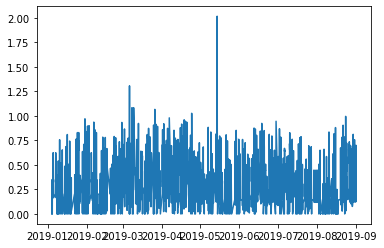

In [299]:
plt.figure()
plt.plot(curr.OccupancyDateTime, curr.PercentOccupied)
plt.show()

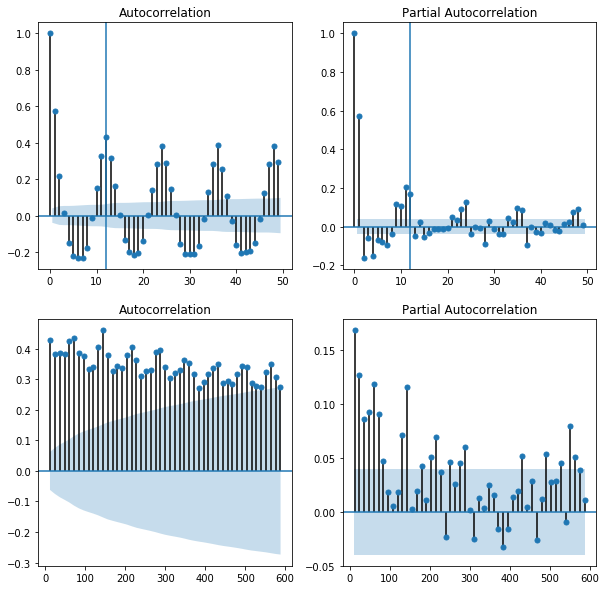

In [300]:
seasonality=12
lags = np.arange(seasonality, seasonality*50, seasonality)

fig, axs = plt.subplots(2,2, figsize=(10,10))

(ax1, ax2, ax3, ax4) = axs.ravel()
plot_acf(pct_occupied, ax=ax1, lags=np.arange(50))
ax1.axvline(seasonality)
plot_pacf(pct_occupied, ax=ax2, lags=np.arange(50))
ax2.axvline(seasonality)
plot_acf(pct_occupied, ax=ax3, lags=lags)
plot_pacf(pct_occupied, ax=ax4, lags=lags)
#ax1.axvline(36)
plt.show()

In [301]:
# from pmdarima.arima import ARIMA
# import pickle
# #for block in blockface_detail.sourceelementkey.values[:1]:
# print(len(pct_occupied))


# tr, tt = pct_occupied.iloc[:7500], pct_occupied.iloc[7500:]

# pkl = open('arima.pkl', 'rb')

# mdl = pickle.load(pkl)

# # mdl = auto_arima(tr, error_action='ignore', trace=True,
# #                      start_p=1, start_q=1, start_P=1, start_Q=1,
# #                      max_p=3, max_q=3, max_P=3, max_Q=3,
# #                       seasonal=True, m=45)
# preds, conf_int = mdl.predict(n_periods=tt.shape[0], return_conf_int=True)


# print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(tt, preds)))


In [302]:
# # #############################################################################
# # Plot the points and the forecasts
# x_axis = curr.OccupancyDateTime

# marker_size = 2
# #x_years = x_axis  # Year starts at 1821

# fig, (ax, ax2) = plt.subplots(2,1, sharex=True)
# #plt.plot(x_axis[:tr.shape[0]], tr, alpha=0.75)
# ax.scatter(x_axis[tr.shape[0]:], preds, c='orange', alpha=0.75, s=marker_size)  # Forecasts
# ax.scatter(x_axis[tr.shape[0]:], tt, s=marker_size , 
#             alpha=0.4, c='b')  # Test data
# ax.fill_between(x_axis[-preds.shape[0]:],
#                  conf_int[:, 0], conf_int[:, 1],
#                  alpha=0.1, color='b')
# ax.set_title("Parking")

# ax2.plot(x_axis[tr.shape[0]:], np.abs(preds-tt))
# plt.setp( ax.xaxis.get_majorticklabels(), rotation=70 )
# ax.set_xlim([datetime.date(2019, 7, 23), datetime.date(2019, 8, 28)])
# ax.set_ylim(0,1)

# #plt.xlabel("Year")
# plt.show()

# arima_smape = smape_error(preds, tt)
# print('smape: %f' % arima_smape)

In [303]:
# fig, (ax, ax2) = plt.subplots(2,1, sharex=True)
# #plt.plot(x_axis[:tr.shape[0]], tr, alpha=0.75)
# ax.scatter(x_axis[tr.shape[0]:], preds, c='orange', alpha=0.75, s=marker_size)  # Forecasts
# ax.scatter(x_axis[tr.shape[0]:], tt, s=marker_size , 
#             alpha=0.4, c='b')  # Test data
# ax.fill_between(x_axis[-preds.shape[0]:],
#                  conf_int[:, 0], conf_int[:, 1],
#                  alpha=0.1, color='b')
# ax.set_title("Parking")

# ax2.plot(x_axis[tr.shape[0]:], np.abs(preds-tt))
# plt.setp( ax.xaxis.get_majorticklabels(), rotation=70 )
# ax.set_xlim([datetime.date(2019, 7, 23), datetime.date(2019, 7, 28)])
# ax.set_ylim(0,1)

# #plt.xlabel("Year")
# plt.show()


In [304]:
# mdl.summary()

## Sarima for all blocks

In [305]:
df.head()

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied
0,1001,2012-01-03 09:00:00,0.983333,7.0,0.140476
1,1001,2012-01-03 10:00:00,2.016667,7.0,0.288095
2,1001,2012-01-03 11:00:00,4.633333,7.0,0.661905
3,1001,2012-01-03 12:00:00,3.283333,7.0,0.469048
4,1001,2012-01-03 13:00:00,1.116667,7.0,0.159524


In [306]:
# start_date = '2019-01-01'
# block = 1001
# mask = (df['SourceElementKey'] == block) & (df['OccupancyDateTime'] > (start_date))

# curr = df[mask]
# time_chunks_per_day = curr.groupby(curr.OccupancyDateTime.dt.dayofyear).count().SourceElementKey.max()
# pct_occupied = curr.PercentOccupied

# num_split = int(.7*len(pct_occupied))

# train, test = pct_occupied.iloc[:num_split], pct_occupied.iloc[num_split:]

In [307]:
# seasonality = 37

# lags = np.arange(seasonality, seasonality*50, seasonality)

# fig, axs = plt.subplots(2,2, figsize=(10,10))

# (ax1, ax2, ax3, ax4) = axs.ravel()
# plot_acf(pct_occupied, ax=ax1, lags=np.arange(50))
# ax1.axvline(seasonality)
# plot_pacf(pct_occupied, ax=ax2, lags=np.arange(50))
# ax2.axvline(seasonality)
# plot_acf(pct_occupied, ax=ax3, lags=lags)
# plot_pacf(pct_occupied, ax=ax4, lags=lags)
# #ax1.axvline(36)
# plt.show()

In [308]:


# model1 = ARIMA(order=(1, 0, 1), seasonal_order=(1, 0, 1, time_chunks_per_day))
# preds = model1.fit_predict(y=train, n_periods=test.shape[0])

# arima_smape = smape_error(preds, test)
# #print('smape: %f' % arima_smape)
# print("Test RMSE: %.3f\t SMAPE: %.3f" % (np.sqrt(mean_squared_error(test, preds)), arima_smape))

In [309]:
import pickle

In [311]:
df['Dummy'] = 0

In [316]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose':-1, 
}

In [321]:
start_date = '2019-01-01'
for block in blockface_detail.sourceelementkey.values[:10]:
    mask = (df['SourceElementKey'] == block) & (df['OccupancyDateTime'] > (start_date))

    curr = df[mask]
    time_chunks_per_day = curr.groupby(curr.OccupancyDateTime.dt.dayofyear).count().SourceElementKey.max()
    pct_occupied = curr.PercentOccupied
    
    num_split = int(.7*len(pct_occupied))
    
    train, test = pct_occupied.iloc[:num_split], pct_occupied.iloc[num_split:]
    df_train, df_test = curr.iloc[:num_split], curr.iloc[num_split:]
    pkl = open('arima.%d.pkl' % block, 'rb')
    mdl = pickle.load(pkl)
    preds = mdl.predict(n_periods=test.shape[0])
    mdl_dict = mdl.to_dict()
    print(block, mdl_dict['order'], mdl_dict['seasonal_order'])
    
#     model1 = ARIMA(order=(1, 0, 1), seasonal_order=(1, 0, 1, time_chunks_per_day))
#     preds = model1.fit_predict(y=train, n_periods=test.shape[0])

    arima_smape = smape_error(preds, test)
    #print('smape: %f' % arima_smape)

#     d1 = pm.arima.ndiffs(pct_occupied, max_d=20)
#     d2 = pm.arima.ndiffs(pct_occupied, max_d=20, test='adf')
#     D1 = pm.arima.nsdiffs(pct_occupied, time_chunks_per_day, max_D=20)
#     D2 = pm.arima.nsdiffs(pct_occupied, time_chunks_per_day, max_D=20, test='ch')
#     print(block, d1,d2, D1, D2)

    lgb_train = lgb.Dataset(data=df_train[baseline_columns], 
                            label=df_train['PercentOccupied'], 
                            feature_name=baseline_columns, 
                            categorical_feature=['SourceElementKey'])
    lgb_test = lgb.Dataset(data=df_test[baseline_columns], 
                           label=df_test['PercentOccupied'], 
                           feature_name=baseline_columns, 
                           categorical_feature=['SourceElementKey'],
                           reference=lgb_train)
    gbm = lgb.train(params,
                lgb_train,
               valid_sets=lgb_test,
                   verbose_eval=False)
    gbm_pred = gbm.predict(df_test[baseline_columns], num_iteration=gbm.best_iteration)
    gbm_smape = smape_error(gbm_pred, df_test['PercentOccupied'])
    print("Test RMSE: %.3f\t SMAPE: %.3f\t GBM SMAPE: %.3f" % (
        np.sqrt(mean_squared_error(test, preds)), arima_smape, gbm_smape))


1001 (3, 1, 3) (2, 0, 2, 10)
Test RMSE: 0.233	 SMAPE: 30.827	 GBM SMAPE: 34.435


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


1002 (1, 1, 1) (1, 0, 1, 10)
Test RMSE: 0.197	 SMAPE: 30.916	 GBM SMAPE: 37.279


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


1006 (0, 0, 0) (4, 0, 2, 12)
Test RMSE: 0.172	 SMAPE: 23.859	 GBM SMAPE: 33.132


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


1009 (1, 1, 1) (3, 0, 3, 12)
Test RMSE: 0.219	 SMAPE: 35.347	 GBM SMAPE: 38.521


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


1010 (1, 1, 1) (1, 0, 1, 12)
Test RMSE: 0.227	 SMAPE: 19.595	 GBM SMAPE: 24.154


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


1013 (1, 0, 2) (1, 0, 1, 12)
Test RMSE: 0.286	 SMAPE: 36.428	 GBM SMAPE: 35.463


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


1014 (2, 1, 1) (2, 0, 1, 12)
Test RMSE: 0.201	 SMAPE: 72.228	 GBM SMAPE: 53.031


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


1017 (0, 1, 0) (2, 0, 1, 12)
Test RMSE: 0.211	 SMAPE: 10.032	 GBM SMAPE: 19.783


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


1018 (2, 1, 1) (2, 0, 2, 12)
Test RMSE: 0.210	 SMAPE: 9.520	 GBM SMAPE: 16.270


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


1021 (2, 1, 1) (1, 0, 1, 12)
Test RMSE: 0.223	 SMAPE: 21.331	 GBM SMAPE: 23.047


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [ ]:
def using_Grouper(df):
    level_values = df.index.get_level_values
    return (df.groupby([level_values(0)]
                       +[pd.Grouper(freq='1D', level=-1)]).sum())

In [ ]:
daily_data = using_Grouper(pd.read_pickle('1.collect_data/data_files/15min.pkl').dropna())


In [ ]:
daily_data.head()

In [ ]:
# shift values by one
pred_values = pd.concat([pd.Series([0]), daily_data['PaidOccupancy']])
timeseries_smape = smape_error(pred_values.values[:-1], daily_data['PaidOccupancy'])
print('smape: %f' % timeseries_smape)